<h2>Formula 1 Grand Prix result prediction</h2>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import pickle
from lightgbm import LGBMRegressor, plot_importance
from autogluon.tabular import TabularPredictor

plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

D:\f1-fantasy-ml-api\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Data cleaning</h3>

In [2]:
rounds = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_round.csv')
round_entries = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_roundentry.csv')
sessions = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_session.csv')
session_entries = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_sessionentry.csv')
team_drivers = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_teamdriver.csv')
drivers = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_driver.csv')
teams = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_team.csv')
circuits = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_circuit.csv')
laps = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_lap.csv')

race_weather = pd.read_csv(r'../data/raw/race_weather.csv')
circuit_type = pd.read_csv(r'../data/raw/circuit_type.csv')

In [3]:
df1 = pd.merge(rounds, sessions, how='left', left_on='id', right_on='round_id', suffixes=('_round', '_session'))
df2 = pd.merge(df1,round_entries,how='left',left_on='id_round', right_on='round_id', suffixes=('', '_round_entry'))
df2 = df2.rename(columns={'id': 'id_round_entry'})
df3 = pd.merge(df2,session_entries,how='left',left_on=['id_round_entry', 'id_session'],right_on=['round_entry_id', 'session_id'],suffixes=('', '_session_entry'))
df3 = df3.rename(columns={'id': 'id_session_entry'})
df4 = pd.merge(df3,team_drivers,how='left',left_on='team_driver_id',right_on='id',suffixes=('', '_team_driver'))
df4 = df4.rename(columns={'id': 'id_team_driver'})
df5 = pd.merge(df4,drivers,how='left',left_on='driver_id',right_on='id',suffixes=('', '_driver'))
df5 = df5.rename(columns={'id': 'id_driver'})
df6 = pd.merge(df5,teams,how='left',left_on='team_id',right_on='id',suffixes=('', '_team'))
df6 = df6.rename(columns={'id': 'id_team'})
df7 = pd.merge(df6,circuits,how='left',left_on='circuit_id',right_on='id',suffixes=('', '_circuit'))
df7 = df7.rename(columns={'id': 'id_circuit'})
df8 = pd.merge(df7,laps,how='left',left_on='id_session_entry',right_on='session_entry_id',suffixes=('', '_lap'))
df8 = df8.rename(columns={'id': 'id_lap'})

In [4]:
data = df8

data = data.drop(['abbreviation', 'altitude', 'average_speed', 'base_team_id', 'car_number', 'circuit_id', 'country', 'date_session', 'detail','fastest_lap_rank', 'forename', 'id_circuit', 'id_round', 'id_round_entry', 'id_session', 'id_session_entry', 'id_driver', 'id_team', 'id_team_driver', 'id_lap', 'is_deleted', 'is_eligible_for_points', 'is_entry_fastest_lap', 'latitude', 'locality', 'longitude', 'name', 'name_team', 'name_circuit', 'nationality', 'nationality_team', 'number','number_round', 'number_session', 'permanent_car_number', 'point_system_id', 'points' , 'position', 'position_lap', 'race_number', 'role', 'round_entry_id', 'round_id', 'round_id_round_entry', 'scheduled_laps', 'season_id', 'season_id_team_driver', 'session_entry_id', 'session_id', 'status', 'surname', 'team_driver_id', 'team_id', 'time', 'wikipedia', 'wikipedia_circuit', 'wikipedia_driver', 'wikipedia_team' ],axis=1)
# Target result columns
# Index(['year', 'date', 'driverId', 'grid', 'laps', 'milliseconds', 'driverRef',
#        'forename', 'surname', 'dob', 'nationality', 'name_constructor',
#        'nationality_constructor', 'name_circuit', 'country', 'status',
#        'milliseconds_laptime'],
#       dtype='object')


In [5]:
# renames
data.rename(columns={'date_round':'date',
                     'grid':'qualification_position','country_code':'driver_nationality',
                    'country_code_team':'constructor_nationality'
                    ,'country_code_circuit':'circuit_nationality',
                     'reference_team': 'constructor',
                     'reference': 'driver',
                     'reference_circuit': 'circuit',
                     'date_of_birth':'driver_date_of_birth',
                     'time_session_entry': 'race_duration',
                     'time_lap': 'lap_duration'},inplace=True)

In [75]:
data.tail(10)

,date,is_cancelled_round,is_cancelled_session,type,qualification_position,is_classified,laps_completed,race_duration,driver_id,driver_nationality,driver_date_of_birth,driver,constructor_nationality,constructor,circuit_nationality,circuit,lap_duration
730906,2025-11-30,f,f,Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QAT,losail,NaN
730907,2025-11-30,f,f,Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QAT,losail,NaN
730908,2025-11-30,f,f,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QAT,losail,NaN
730909,2025-12-07,f,f,FP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARE,yas_marina,NaN
730910,2025-12-07,f,f,FP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARE,yas_marina,NaN
730911,2025-12-07,f,f,FP3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARE,yas_marina,NaN
730912,2025-12-07,f,f,Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARE,yas_marina,NaN
730913,2025-12-07,f,f,Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARE,yas_marina,NaN
730914,2025-12-07,f,f,Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARE,yas_marina,NaN
730915,2025-12-07,f,f,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARE,yas_marina,NaN


In [6]:


#Take only  column 'type' of value 'R' as race
data = data[data['type']=='R']
#take only rows where 'is_cancelled_round', 'is_cancelled_session' are 'f'
data = data[(data['is_cancelled_round']=='f')]
data = data[(data['is_cancelled_session']=='f')]

data.drop(['is_cancelled_round', 'is_cancelled_session', 'type'],axis=1,inplace=True)

# drop where is clssified is null or nan
data = data[data['is_classified'].notna()]
data.tail(10)


,date,qualification_position,is_classified,laps_completed,race_duration,driver_id,driver_nationality,driver_date_of_birth,driver,constructor_nationality,constructor,circuit_nationality,circuit,lap_duration
730851,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:45.139
730852,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:44.936
730853,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:45.238
730854,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:44.93
730855,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:45.123
730856,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:45.196
730857,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:47.845
730858,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:45.852
730859,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:45.509
730860,2025-09-21,13.00,t,51.00,01:34:34.014,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:45.38


In [49]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData.dtypes
#export test data to csv
#testData.to_csv('testData.csv', index=False)


date                        object
qualification_position     float64
is_classified               object
laps_completed             float64
race_duration               object
driver_id                  float64
driver_nationality          object
driver_date_of_birth        object
driver                      object
constructor_nationality     object
constructor                 object
circuit_nationality         object
circuit                     object
lap_duration                object
dtype: object

In [50]:
# check if there is any null or nan in any column
print("Null values in each column:")
print(data.isnull().sum())

Null values in each column:
date                            0
qualification_position          0
is_classified                   0
laps_completed                  0
race_duration              280608
driver_id                       0
driver_nationality              0
driver_date_of_birth            0
driver                          0
constructor_nationality         0
constructor                     0
circuit_nationality             0
circuit                         0
lap_duration                14362
dtype: int64


In [7]:
# Specify the date format explicitly
data['date'] = pd.to_datetime(data['date'])
data['driver_date_of_birth'] = pd.to_datetime(data['driver_date_of_birth'])

#get month and day from date into new columns
data['race_month'] = data['date'].dt.month
data['race_day'] = data['date'].dt.day
data['race_year'] = data['date'].dt.year


In [8]:
data['age_at_gp_in_days'] = abs(data['driver_date_of_birth']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driver_id')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driver_id', how='left')
data = data.drop(['driver_id'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [9]:
# load race_weather csv, join by race date
race_weather['date'] = pd.to_datetime(race_weather['date'])
data = data.merge(race_weather, how='left', left_on='date', right_on='date', suffixes=('', '_race_weather'))
data = data[data['weather'].notna()]

In [10]:
#create a rain column where if the weather is 'Rain or 'Changeable' or 'Very changeable' then 1 else 0
data['rain'] = data['weather'].apply(lambda x: 1 if x in ['Rain', 'Changeable', 'Very changeable'] else 0)
#drop the weather column
data = data.drop(['weather'],axis=1)

In [11]:
# Merge circuit type
data = data.merge(circuit_type, how='left', left_on='circuit', right_on='circuit', suffixes=('', '_circuit_type'))

In [12]:
#select all data from 1980
data = data[data['race_year']>=1981]
#get first nationality only


In [83]:
print(data.columns)

Index(['date', 'qualification_position', 'is_classified', 'laps_completed',
       'race_duration', 'driver_nationality', 'driver_date_of_birth', 'driver',
       'constructor_nationality', 'constructor', 'circuit_nationality',
       'circuit', 'lap_duration', 'race_month', 'race_day', 'race_year',
       'age_at_gp_in_days', 'first_race_date', 'days_since_first_race', 'rain',
       'type_circuit'],
      dtype='object')


In [84]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['williams' 'brabham' 'alfa' 'tyrrell' 'theodore' 'fittipaldi' 'renault'
 'ensign' 'ferrari' 'ligier' 'ats' 'arrows' 'osella' 'team_lotus'
 'mclaren' 'march' 'toleman' 'ram' 'spirit' 'minardi' 'zakspeed' 'lola'
 'benetton' 'ags' 'larrousse' 'coloni' 'rial' 'eurobrun' 'dallara' 'onyx'
 'leyton' 'lambo' 'jordan' 'footwork' 'fondmetal' 'moda' 'sauber' 'simtek'
 'pacific' 'forti' 'prost' 'stewart' 'bar' 'jaguar' 'toyota' 'red_bull'
 'honda' 'toro_rosso' 'bmw_sauber' 'mf1' 'super_aguri' 'spyker_mf1'
 'spyker' 'force_india' 'brawn' 'mercedes' 'lotus_racing' 'hrt' 'virgin'
 'lotus_f1' 'marussia' 'caterham' 'manor' 'haas' 'racing_point'
 'alphatauri' 'aston_martin' 'alpine' 'rb']


In [85]:
data['constructor_nationality'].unique()


array(['GBR', 'CHE', 'HKG', 'BRA', 'FRA', 'ITA', 'DEU', 'IRL', 'JPN',
       'AUT', 'RUS', 'NLD', 'IND', 'MYS', 'ESP', 'USA'], dtype=object)

In [13]:
#data after processing nationalities
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


In [14]:
def time_to_milliseconds(time_str):
    if pd.isnull(time_str):
        return None
    try:
        # Split milliseconds
        if '.' in time_str:
            time_part, ms_part = time_str.split('.')
            ms = int(ms_part.ljust(3, '0'))  # pad to 3 digits
        else:
            time_part = time_str
            ms = 0
        dt = datetime.strptime(time_part, "%H:%M:%S")
        total_ms = (dt.hour * 3600 + dt.minute * 60 + dt.second) * 1000 + ms
        return total_ms
    except Exception:
        return None

data['milliseconds'] = data['race_duration'].apply(time_to_milliseconds)
# fill milliseconds null with 0
data['milliseconds'] = data['milliseconds'].fillna(0)
data['milliseconds_laptime'] = data['lap_duration'].apply(time_to_milliseconds)
data['milliseconds_laptime'] = data['milliseconds_laptime'].fillna(0)

# drop race_duration and lap_duration
data = data.drop(['race_duration', 'lap_duration'],axis=1)

<h5>Data median </h5>

In [131]:
data.tail(10)

In [15]:
data_group_for_race_time = data.copy()
# Group by all columns except 'milliseconds_laptime', summing 'milliseconds_laptime' into a new column

columns_to_group = [col for col in data_group_for_race_time.columns if col != 'milliseconds_laptime']
data_group_for_race_time = data_group_for_race_time.groupby(columns_to_group, as_index=False).agg(
    milliseconds_laptime=('milliseconds_laptime', 'sum'),
    laps_count=('milliseconds_laptime', 'count')
)


# Convert columns to numeric
data_group_for_race_time['milliseconds_laptime'] = pd.to_numeric(data_group_for_race_time['milliseconds_laptime'], errors='coerce')
data_group_for_race_time['milliseconds'] = pd.to_numeric(data_group_for_race_time['milliseconds'], errors='coerce')
# Replace '\N' with 0 in both columns
data_group_for_race_time['milliseconds_laptime'] = data_group_for_race_time['milliseconds_laptime'].fillna(0)
data_group_for_race_time['milliseconds'] = data_group_for_race_time['milliseconds'].fillna(0)

#create col [time_exist] which is 1 where both 'milliseconds_laptime' and 'milliseconds' are not null or 0
data_group_for_race_time['time_exist'] = np.where(
    (data_group_for_race_time['milliseconds_laptime'].notna() & (data_group_for_race_time['milliseconds_laptime'] != 0)) |
    (data_group_for_race_time['milliseconds'].notna() & (data_group_for_race_time['milliseconds'] != 0)),
    1, 0
)

data_group_for_race_time_filtered = data_group_for_race_time.copy()
# Filter rows where 'time_exist' == 0
data_group_for_race_time_filtered = data_group_for_race_time_filtered[data_group_for_race_time_filtered['time_exist'] != 0]

# Drop the 'time_exist' column
data_group_for_race_time_filtered.drop(['time_exist'], axis=1, inplace=True)


data_group_for_race_time_filtered['race_duration'] = data_group_for_race_time_filtered.apply(
    lambda row: row['milliseconds_laptime'] if row['milliseconds_laptime'] != 0 else row['milliseconds'], axis=1
)

# Drop the 'milliseconds' and 'milliseconds_laptime' columns
#data_group_for_race_time_filtered = data_group_for_race_time_filtered.drop(['milliseconds', 'milliseconds_laptime'], axis=1)

data_group_for_race_time_filtered['laps_completed'] = data_group_for_race_time_filtered.apply(
    #lambda row: row['laps'] if row['laps'] !=0 else row['laps_count'], axis=1
    lambda row: row['laps_completed'] if row['laps_completed'] >= row['laps_count'] else row['laps_count'], axis=1
)
data_group_for_race_time_filtered = data_group_for_race_time_filtered.drop(['laps_count'], axis=1)

#print sort by date
data_group_for_race_time_filtered.sort_values(by=['date'], ascending=True)
#data = data_group_for_race_time_filtered





,date,qualification_position,is_classified,laps_completed,driver_nationality,driver_date_of_birth,driver,constructor_nationality,constructor,circuit_nationality,...,age_at_gp_in_days,first_race_date,days_since_first_race,rain,type_circuit,driver_home,constructor_home,milliseconds,milliseconds_laptime,race_duration
1,1981-03-15,2.00,t,80.00,AUS,1946-11-02,jones,GBR,williams,USA,...,12552,1975-04-27,2149,0,Street circuit,0,0,6641330.00,0.00,6641330.00
2,1981-03-15,3.00,t,80.00,ARG,1942-04-12,reutemann,GBR,williams,USA,...,14217,1972-01-23,3339,0,Street circuit,0,0,6650520.00,0.00,6650520.00
3,1981-03-15,4.00,t,80.00,BRA,1952-08-17,piquet,GBR,brabham,USA,...,10437,1978-07-30,959,0,Street circuit,0,0,6676250.00,0.00,6676250.00
5,1981-03-15,6.00,t,80.00,USA,1940-02-28,mario_andretti,CHE,alfa,USA,...,14991,1968-10-06,4543,0,Street circuit,1,0,6690640.00,0.00,6690640.00
7,1981-03-15,8.00,t,80.00,USA,1958-01-10,cheever,GBR,tyrrell,USA,...,8465,1978-03-04,1107,0,Street circuit,1,0,6708030.00,0.00,6708030.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17907,2025-09-21,2.00,t,51.00,ESP,1994-09-01,sainz,GBR,williams,AZE,...,11343,2015-03-15,3843,0,Street circuit,0,0,5625607.00,5625607.00,5625607.00
17906,2025-09-21,1.00,t,51.00,NLD,1997-09-30,max_verstappen,AUT,red_bull,AZE,...,10218,2015-03-15,3843,0,Street circuit,0,0,5606408.00,5606408.00,5606408.00
17924,2025-09-21,19.00,t,51.00,THA,1996-03-23,albon,GBR,williams,AZE,...,10774,2019-03-17,2380,0,Street circuit,0,0,5679278.00,5669278.00,5669278.00
17915,2025-09-21,10.00,t,51.00,MCO,1997-10-16,leclerc,ITA,ferrari,AZE,...,10202,2018-03-25,2737,0,Street circuit,0,0,5643182.00,5643182.00,5643182.00


In [16]:
# Group by circuit and year, take laps as max lap in the group
data_with_max_laps = data_group_for_race_time_filtered.copy()

data_with_max_laps['max_laps'] = data_with_max_laps.groupby(['circuit', 'race_year', 'date'])['laps_completed'].transform('max')

# Select relevant columns
data_with_max_laps = data_with_max_laps[['circuit', 'race_year','date', 'max_laps']]
# Drop duplicates
data_with_max_laps = data_with_max_laps.drop_duplicates()


In [17]:
data_median = data_group_for_race_time_filtered.copy()

#drop rows with laps = 0
data_median = data_median[data_median['laps_completed'] >10]
#join with data_with_max_laps on circuit and year
data_median = data_median.merge(data_with_max_laps, on=['circuit', 'race_year', 'date'], how='left')
#drop duplicates
data_median = data_median.drop_duplicates()
#take abs value of max_laps - laps and assign to new column as additional_laps
data_median['additional_laps'] = abs(data_median['max_laps'] - data_median['laps_completed'])
#drop max_laps column
#data_median = data_median.drop(['max_laps'], axis=1)
data_median['laps'] = data_median['max_laps']
# Apply the condition
condition = data_median['is_classified'].eq('t')

# Perform the calculation only for rows satisfying the condition
data_median.loc[condition, 'final_race_duration'] = (
    data_median['race_duration'] + 
    data_median['race_duration'] / data_median['laps_completed'] * data_median['additional_laps']
)
data_median['final_race_duration'] = data_median['final_race_duration'].fillna(data_median['race_duration'])
#drop laps column
#data_median = data_median.drop(['laps'], axis=1)
 #drop additional_laps column
#data_median = data_median.drop(['additional_laps'], axis=1)
#drop duplicates
data_median = data_median.drop_duplicates()

data_median.columns

Index(['date', 'qualification_position', 'is_classified', 'laps_completed',
       'driver_nationality', 'driver_date_of_birth', 'driver',
       'constructor_nationality', 'constructor', 'circuit_nationality',
       'circuit', 'race_month', 'race_day', 'race_year', 'age_at_gp_in_days',
       'first_race_date', 'days_since_first_race', 'rain', 'type_circuit',
       'driver_home', 'constructor_home', 'milliseconds',
       'milliseconds_laptime', 'race_duration', 'max_laps', 'additional_laps',
       'laps', 'final_race_duration'],
      dtype='object')

In [18]:
data_median_race_duration = data_median.groupby(['circuit', 'race_year', 'date'])['final_race_duration'].median().reset_index()
#rename col to median_race_duration
data_median_race_duration.rename(columns={'final_race_duration': 'median_race_duration'},inplace=True)

#merge with data_median
data_median = data_median.merge(data_median_race_duration, on=['circuit', 'race_year', 'date'], how='left')

#create column deviation from median and equal to abs of race_duration - median_race_duration
data_median['deviation_from_median'] = data_median['final_race_duration'] - data_median['median_race_duration']


data_median = data_median[data_median['is_classified'].eq('t')]

#round all numbers in num columns
num_cols = data_median.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data_median[col] = data_median[col].round()

#convert deviation_from_median to seconds
#data_median['deviation_from_median'] = data_median['deviation_from_median'] / 1000

#drop rows with deviation_from_median < -200000
data_median = data_median[(data_median['deviation_from_median'] > -110000) & (data_median['deviation_from_median'] < 612000)]

#drop median_race_duration and race_duration


In [22]:
# Create a copy of the dataset
data_export = data_median.copy()

# Apply the condition
condition = data_export['is_classified'].eq('t')

# Assign final_position only to rows that meet the condition
data_export['final_position'] = np.nan  # Initialize with NaN
data_export.loc[condition, 'final_position'] = (
    data_export[condition]
    .groupby(['race_year', 'race_month', 'race_day', 'circuit'])['deviation_from_median']
    .rank(method='min', ascending=True)
)

# Rename columns and export to CSV
data_export.rename(columns={'qualification_pos': 'qualification_position', 'max_laps': 'laps', 'date': 'race_date'}, inplace=True)
data_export.to_csv('data_median.csv', index=False)

In [23]:
#export 'driver', 'driver_date_of_birth', 'first_race_date', 'driver_nationality' unique driver data
unique_driver_data = data_median[['driver', 'driver_date_of_birth', 'first_race_date', 'driver_nationality']]

# Drop duplicate rows
unique_driver_data = unique_driver_data.drop_duplicates()

# Export to CSV
unique_driver_data.to_csv('unique_driver_data.csv', index=False)

# data_median[['driver', 'driver_date_of_birth', 'first_race_date', 'driver_nationality']].to_csv('drivers_fe.csv', index=False)
#export unique circuit data
unique_circuit_data = data_median[['circuit', 'type_circuit', 'circuit_nationality']]
unique_circuit_data = unique_circuit_data.drop_duplicates()
# Export to CSV
unique_circuit_data.to_csv('unique_circuit_data.csv', index=False)

#export unique constructor data
unique_constructor_data = data_median[['constructor', 'constructor_nationality']]
unique_constructor_data = unique_constructor_data.drop_duplicates()
# Export to CSV
unique_constructor_data.to_csv('unique_constructor_data.csv', index=False)

In [19]:
# Group by 'year' and 'circuit' and count unique 'race_date' values
duplicate_dates = data_median.groupby(['race_year','race_month', 'race_day', 'circuit'])['date'].nunique()

# Filter groups where there are multiple unique dates
duplicate_dates = duplicate_dates[duplicate_dates > 1]

# Display the results
if not duplicate_dates.empty:
    print("Situations with same race_year and circuit but different dates:")
    print(duplicate_dates)
else:
    print("No such situations found.")

No such situations found.


<h3>Testing different models on cleaned median data</h3>

In [100]:
data_median.columns

Index(['date', 'qualification_position', 'is_classified', 'laps_completed',
       'driver_nationality', 'driver_date_of_birth', 'driver',
       'constructor_nationality', 'constructor', 'circuit_nationality',
       'circuit', 'race_month', 'race_day', 'race_year', 'age_at_gp_in_days',
       'first_race_date', 'days_since_first_race', 'rain', 'type_circuit',
       'driver_home', 'constructor_home', 'milliseconds',
       'milliseconds_laptime', 'race_duration', 'max_laps', 'additional_laps',
       'laps', 'final_race_duration', 'median_race_duration',
       'deviation_from_median'],
      dtype='object')

In [20]:
# Drop irrelevant columns
columns_to_drop = [ 'driver_date_of_birth', 'date', 'first_race_date', 'additional_laps', 'is_classified', 'laps_completed','milliseconds',
       'milliseconds_laptime', 'race_duration', 'max_laps', 'final_race_duration', 'median_race_duration']
cleaned_data_median = data_median.drop(columns=columns_to_drop)

cleaned_data_median.dtypes

qualification_position     float64
driver_nationality          object
driver                      object
constructor_nationality     object
constructor                 object
circuit_nationality         object
circuit                     object
race_month                   int32
race_day                     int32
race_year                    int32
age_at_gp_in_days            int64
days_since_first_race        int64
rain                         int64
type_circuit                object
driver_home                  int64
constructor_home             int64
laps                       float64
deviation_from_median      float64
dtype: object

<h4>Split data</h4>


In [21]:
# Create a unique identifier for each race
cleaned_data_median['race_id'] = cleaned_data_median['race_year'].astype(str) + '_' + cleaned_data_median['race_month'].astype(str) + '_' + cleaned_data_median['race_day'].astype(str) + '_' + cleaned_data_median['circuit']

# Get unique race identifiers
race_ids = cleaned_data_median['race_id'].unique()

# Split race identifiers into training and testing sets
train_race_ids, test_race_ids = train_test_split(race_ids, test_size=0.2, random_state=42)

# Filter the original dataset for training and testing sets
X_train = cleaned_data_median[cleaned_data_median['race_id'].isin(train_race_ids)]
X_test = cleaned_data_median[cleaned_data_median['race_id'].isin(test_race_ids)]


test_set_with_result = X_test.copy()
test_set_with_result['final_position'] = test_set_with_result.groupby(['race_id'])['deviation_from_median'].rank(method='min', ascending=True)

# set_with_result = cleaned_data_median.copy()
# set_with_result['final_position'] = cleaned_data_median.groupby(['race_id'])['deviation_from_median'].rank(method='min', ascending=True)
# set_with_result.to_csv('cleaned_data_median_with_ranking.csv', index=False)


# Drop the temporary race_id column
X_train = X_train.drop(columns=['race_id'])
X_test = X_test.drop(columns=['race_id'])


# Separate features and target
y_train = X_train['deviation_from_median']
X_train = X_train.drop(columns=['deviation_from_median'])


y_test = X_test['deviation_from_median']
X_test = X_test.drop(columns=['deviation_from_median'])



<h4>Custom metric function</h4>

In [46]:
def get_weight(pos):
    if pos <= 5:
        return 3
    elif pos <= 10:
        return 2
    else:
        return 1

def get_race_weight(circuit, race_year, race_month, race_day, df):
    #return 0.5 if total entries < 10, else return 1
    #count filter df by circuit, race_year, race_month, race_day
    filtered_df = df[
    (df['circuit'] == circuit) &
    (df['race_year'] == race_year) &
    (df['race_month'] == race_month) &
    (df['race_day'] == race_day)
    ]
    
    # Count the number of entries in the filtered DataFrame
    entry_count = len(filtered_df)
    if(entry_count <5):
        return 0.2
    elif (entry_count < 10):
        return 0.5
    else:
        return 1
    
    
    
def weighted_position_error( y_true_df, X_test, ml_model):
    
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)

    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results = []
    
    #loop each row
    for index, row in joined_df.iterrows():
        # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']

        # Weight based on true rank
        

        weight = get_weight(true_pos)
        race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
        pos_error = abs(true_pos - pred_pos)
        weighted_error = race_weight* weight * pos_error

        results.append(weighted_error)
    

   
    return np.mean(results)

def get_top_5_error( y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results_top5 = []
    
    #loop each row
    for index, row in joined_df.iterrows():
    # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']
        if(true_pos <= 5):
            weight = get_weight(true_pos)
            race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
            pos_error = abs(true_pos - pred_pos)
            weighted_error = race_weight* weight * pos_error
        
            results_top5.append(weighted_error)
    return np.mean(results_top5)
    
def calculate_general_errors_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')

    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae

def calculate_general_errors_top5_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    # check for the column name predicted_deviation_from_median, if not exist, try column deviation_from_median
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    print(y_pred_df)
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    
    #drop rows where final_position > 5
    joined_df = joined_df[joined_df['final_position'] <= 5]

    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae


SyntaxError: invalid syntax. Perhaps you forgot a comma? (410678991.py, line 34)

In [23]:
robust_cols = ['qualification_position', 'age_at_gp_in_days', 'days_since_first_race', 'laps', 'race_year']
cat_cols = ['constructor','circuit','type_circuit','driver','circuit_nationality','driver_nationality','constructor_nationality', 'race_month','race_day', 'rain', 'driver_home', 'constructor_home']
other_cols = []


<h2>Autogluon</h2

In [26]:
# Combine X_train and y_train for AutoGluon
train_data = X_train.copy()
train_data['deviation_from_median'] = y_train

# Initialize and fit predictor
predictor = TabularPredictor(label='deviation_from_median', path='../models/autogluon_models/main_race_predictor', problem_type='regression', eval_metric='root_mean_squared_error').fit(train_data, presets='medium_quality').save()


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.8
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       30.26 GB / 63.11 GB (47.9%)
Disk Space Avail:   645.74 GB / 976.56 GB (66.1%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ...
AutoGluon will save models to "D:\f1-fantasy-ml-api\models\autogluon_models\main_race_predictor"
Train Data Rows:    7794
Train Data Columns: 17
Label Column:       deviation_from_median
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30980.98 MB
	Train Data (Original)  Memory Usage: 3.80 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature

In [29]:
predictor = TabularPredictor.load('../models/autogluon_models/main_race_predictor')

# Predict on test set
y_pred = predictor.predict(X_test)

# Evaluate
perf = predictor.evaluate(X_test.assign(deviation_from_median=y_test))
print(perf)

{'root_mean_squared_error': np.float64(-56137.08245373332), 'mean_squared_error': -3151372026.417253, 'mean_absolute_error': -32553.38438238993, 'r2': 0.5209389843454824, 'pearsonr': 0.7220522424498147, 'median_absolute_error': -21514.01953125}


In [31]:
performance = predictor.evaluate(X_test.assign(deviation_from_median=y_test))
performance

{'root_mean_squared_error': np.float64(-56137.08245373332),
 'mean_squared_error': -3151372026.417253,
 'mean_absolute_error': -32553.38438238993,
 'r2': 0.5209389843454824,
 'pearsonr': 0.7220522424498147,
 'median_absolute_error': -21514.01953125}

In [32]:
predictor.leaderboard(X_test.assign(deviation_from_median=y_test))

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-56137.08,-40152.95,root_mean_squared_error,0.11,0.03,59.19,0.00,0.00,0.01,2,True,10
1,CatBoost,-56250.05,-41734.91,root_mean_squared_error,0.02,0.01,53.18,0.02,0.01,53.18,1,True,4
2,LightGBM,-56772.74,-42717.66,root_mean_squared_error,0.01,0.01,0.41,0.01,0.01,0.41,1,True,2
3,LightGBMLarge,-56863.69,-42301.95,root_mean_squared_error,0.03,0.01,1.13,0.03,0.01,1.13,1,True,9
4,LightGBMXT,-56995.12,-42650.01,root_mean_squared_error,0.01,0.01,2.18,0.01,0.01,2.18,1,True,1
5,RandomForestMSE,-57343.02,-43304.09,root_mean_squared_error,0.16,0.04,1.31,0.16,0.04,1.31,1,True,3
6,XGBoost,-57367.70,-40784.43,root_mean_squared_error,0.02,0.01,0.90,0.02,0.01,0.90,1,True,7
7,NeuralNetTorch,-57587.47,-44924.25,root_mean_squared_error,0.01,0.01,7.76,0.01,0.01,7.76,1,True,8
8,ExtraTreesMSE,-57848.84,-44512.46,root_mean_squared_error,0.14,0.04,0.59,0.14,0.04,0.59,1,True,5
9,NeuralNetFastAI,-58387.96,-44677.90,root_mean_squared_error,0.03,0.01,3.96,0.03,0.01,3.96,1,True,6


In [33]:
predictor.feature_importance(X_test.assign(deviation_from_median=y_test))

Computing feature importance via permutation shuffling for 17 features using 2008 rows with 5 shuffle sets...
	8.94s	= Expected runtime (1.79s per shuffle set)
	3.39s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
qualification_position,12799.79,325.08,0.00,5,13469.12,12130.45
constructor,6488.16,603.96,0.00,5,7731.73,5244.59
race_year,3021.67,367.30,0.00,5,3777.95,2265.39
driver,1641.22,258.75,0.00,5,2173.99,1108.45
days_since_first_race,1509.60,332.73,0.00,5,2194.70,824.51
constructor_nationality,982.46,286.65,0.00,5,1572.69,392.24
age_at_gp_in_days,743.59,107.01,0.00,5,963.91,523.26
driver_nationality,617.64,130.34,0.00,5,886.01,349.27
race_month,243.41,117.44,0.00,5,485.21,1.61
rain,170.81,70.67,0.00,5,316.33,25.29


In [48]:
y_pred = predictor.predict(X_test)
y_pred

12      -18045.42
13      -20013.00
14      -10068.88
15       -6391.86
16       -6656.96
           ...   
11796    31483.44
11797    37816.09
11798    35297.18
11799    34320.48
11800    23296.92
Name: deviation_from_median, Length: 2008, dtype: float32

In [34]:

# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, predictor)
print(f"Weighted Position Error Autogluon: {wpe:.2f}")

wpe5 = get_top_5_error( test_set_with_result, X_test, predictor)
print(f"Top 5 Weighted Position Error Autogluon: {wpe5:.2f}")

# Calculate general errors
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, predictor)
print(f"General Errors Autogluon: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, predictor)
print(f"General Errors Top 5 Autogluon: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Error Autogluon: nan
Top 5 Weighted Position Error Autogluon: nan


ValueError: Input contains NaN.

<h3> Random forest regressor</h3>

In [180]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#     'model__max_depth': [30],
#     'model__min_samples_leaf': [2, 3, 4],
#     'model__min_samples_split': [10, 15],
#     'model__n_estimators': [600, 800]
# }
param_grid = {'model__max_depth': [30], 'model__min_samples_leaf': [2], 'model__min_samples_split': [10], 'model__n_estimators': [800]}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)
# Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 800}

# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 800}
Best RMSE: 46599.93205192418
Final Model Performance:
MSE: 3201686924.53
RMSE: 56583.45
R2: 0.5133
MAE: 33027.07


C:\Users\Linh\AppData\Local\Temp\ipykernel_23544\1772138597.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


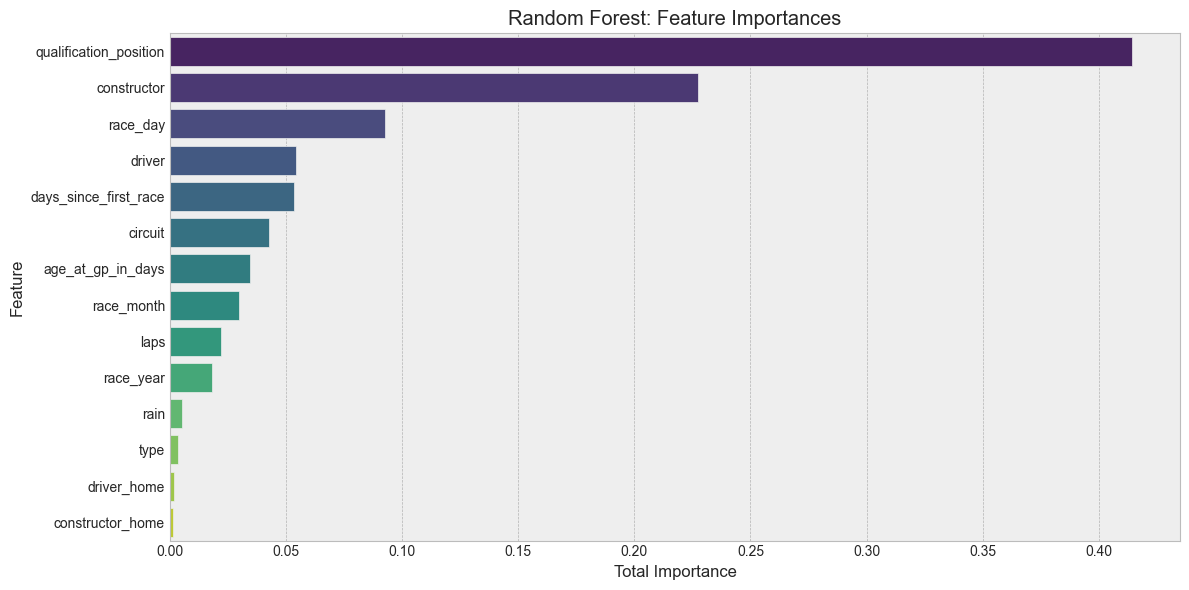

In [181]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Random Forest: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [182]:

# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_rf)
print(f"Weighted Position Error Random Forest: {wpe:.2f}")

wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_rf)
print(f"Top 5 Weighted Position Error Random Forest: {wpe5:.2f}")

# Calculate general errors
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Random Forest: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Top 5 Random Forest: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Error Random Forest: 3.56
Top 5 Weighted Position Error Random Forest: 4.12
General Errors Random Forest: MSE: 8.27, RMSE: 2.88, R2: 0.6910, MAE: 1.98
General Errors Top 5 Random Forest: MSE: 5.44, RMSE: 2.33, R2: -1.7681, MAE: 1.51


In [32]:
# save
# with open('rf.pkl','wb') as f:
#     pickle.dump(best_model_rf,f)

# load
with open('rf.pkl', 'rb') as f:
    best_model_rf = pickle.load(f)


<h5>Gradient boost regressor</h5>

In [183]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')
# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor())
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#     'model__loss': [ 'huber'],
#     'model__learning_rate': [0.01, 0.1],
#     'model__n_estimators': [ 300, 400],
#     'model__min_samples_split': [ 5, 10, 15],
#     'model__min_samples_leaf': [ 4, 5],
#     'model__max_depth': [ 4, 5],
# }
param_grid ={'model__learning_rate': [0.1], 'model__loss': ['huber'], 'model__max_depth': [5], 'model__min_samples_leaf': [4], 'model__min_samples_split': [5], 'model__n_estimators': [400]}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)
# Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}

# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best RMSE: 45982.30861602873
Final Model Performance:
MSE: 3253829346.13
RMSE: 57042.35
R2: 0.5054
MAE: 33173.98


C:\Users\Linh\AppData\Local\Temp\ipykernel_23544\4262997751.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


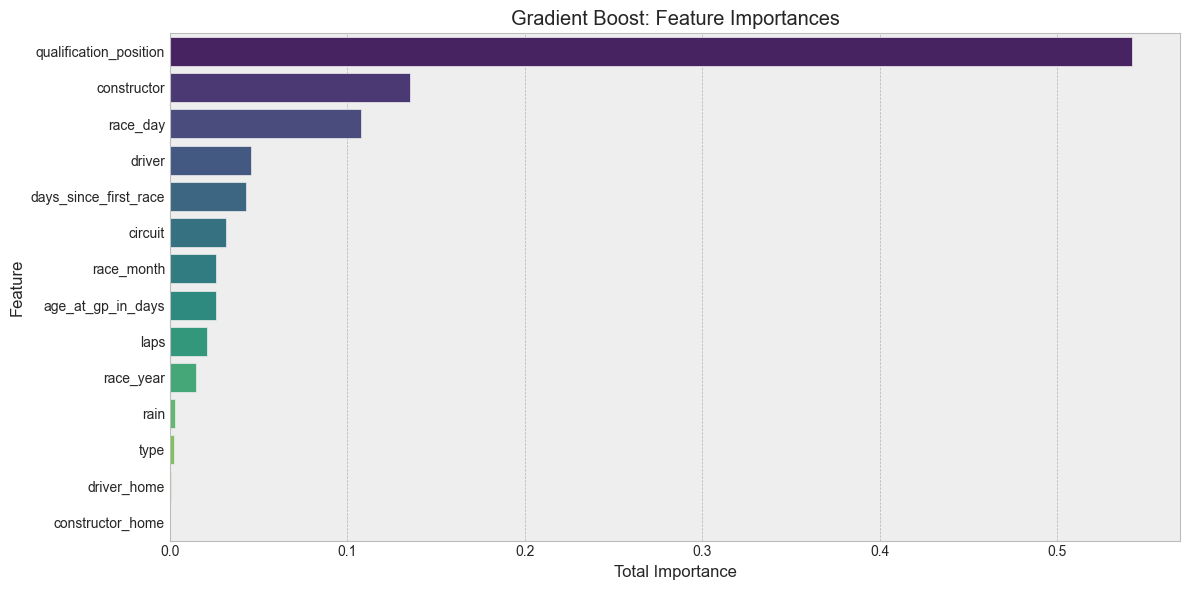

In [184]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_
# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Gradient Boost: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [185]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_gb)
print(f"Weighted Position Gradient Boost: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_gb)
print(f"Top 5 Weighted Position Error Gradient Boost: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Gradient Boost: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Top 5 Gradient Boost: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Gradient Boost: 3.48
Top 5 Weighted Position Error Gradient Boost: 3.92
General Errors Gradient Boost: MSE: 7.89, RMSE: 2.81, R2: 0.7052, MAE: 1.94
General Errors Top 5 Gradient Boost: MSE: 4.87, RMSE: 2.21, R2: -1.4804, MAE: 1.44


In [128]:
# save
# with open('gb.pkl','wb') as f:
#     pickle.dump(best_model_gb,f)

# load
with open('gb.pkl', 'rb') as f:
    best_model_gb = pickle.load(f)

<h5>Neural network</h5>

In [186]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')
# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', MLPRegressor(random_state=42,max_iter=1000 , verbose=1))
])

# param_grid = {
#     'model__hidden_layer_sizes': [ (50, 50), (100, 50)],
#     'model__activation': ['relu', 'tanh'],
#     'model__alpha': [0.0001, 0.001, 0.01],
#     'model__learning_rate_init': [0.001, 0.01],
#     'model__solver': ['adam'],
# }
param_grid = {
    'model__hidden_layer_sizes': [  (100, 100, 100,100,100)],
    'model__activation': ['relu'],
    'model__alpha': [0.001],
    'model__learning_rate_init': [0.001],
    'model__solver': ['adam'],
}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)
# Best Parameters: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50, 50), 'model__learning_rate_init': 0.001, 'model__solver': 'adam'}

# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_nn = grid_search.best_estimator_
y_pred = best_model_nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration 1, loss = 3094020991.26553202
Iteration 2, loss = 2903165513.28066158
Iteration 3, loss = 2895498768.15623188
Iteration 4, loss = 2893508073.00693178
Iteration 5, loss = 2892000459.22339487
Iteration 6, loss = 2893220211.51432228
Iteration 7, loss = 2891410210.95084524
Iteration 8, loss = 2905389638.69484663
Iteration 9, loss = 2896877232.09716463
Iteration 10, loss = 2887330377.77966785
Iteration 11, loss = 2885624872.43681002
Iteration 12, loss = 2884814311.42327738
Iteration 13, loss = 2882507342.04693079
Iteration 14, loss = 2883780031.08617163
Iteration 15, loss = 2877256975.57580423
Iteration 16, loss = 2874165696.40021133
Iteration 17, loss = 2864334619.10466003
Iteration 18, loss = 2848990019.68124676
Iteration 19, loss = 2816872985.06320286
Iteration 20, loss = 2683852260.61337662
Iteration 21, loss = 2242350908.60075665
Iteration 22, loss = 1838648738.87735701
Iteration 23, loss = 1749151726.30483747
Iterati

In [116]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_nn)
print(f"Weighted Position Neural Network: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_nn)
print(f"Top 5 Weighted Position Error Neural Network: {wpe5:.2f}")

mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Gradient  Neural Network: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")

mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Top 5 Neural Network: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Neural Network: 3.02
Top 5 Weighted Position Error Neural Network: 2.69
General Errors Gradient  Neural Network: MSE: 6.40, RMSE: 2.53, R2: 0.6754, MAE: 1.73
General Errors Top 5 Neural Network: MSE: 3.20, RMSE: 1.79, R2: -0.6579, MAE: 1.22


In [32]:
# save
# with open('nn.pkl','wb') as f:
#     pickle.dump(best_model_nn,f)

# load
with open('nn.pkl', 'rb') as f:
    best_model_nn = pickle.load(f)

<h5>LightGBM</h5>

In [118]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# param_grid = {
#     'model__n_estimators': [100, 200, 500],
#     'model__learning_rate': [0.01, 0.05, 0.1],
#     'model__max_depth': [5, 10, 20, -1],  
#     'model__num_leaves': [20, 31, 50, 100],
#     'model__min_child_samples': [5, 10, 20, 30]
# }
param_grid = {
    'model__n_estimators': [ 500],
    'model__learning_rate': [ 0.05],
    'model__max_depth': [ -1],  
    'model__num_leaves': [ 100],
    'model__min_child_samples': [ 20]
}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_lgbm = grid_search.best_estimator_
y_pred = best_model_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 5250, number of used features: 204
[LightGBM] [Info] Start training from score -123.562476
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
Best RMSE: 24322.958757712593
Final Model Performance:
MSE: 622709123.96
RMSE: 24954.14
R2: 0.3298
MAE: 19430.02


D:\f1-fantasy-ml-api\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

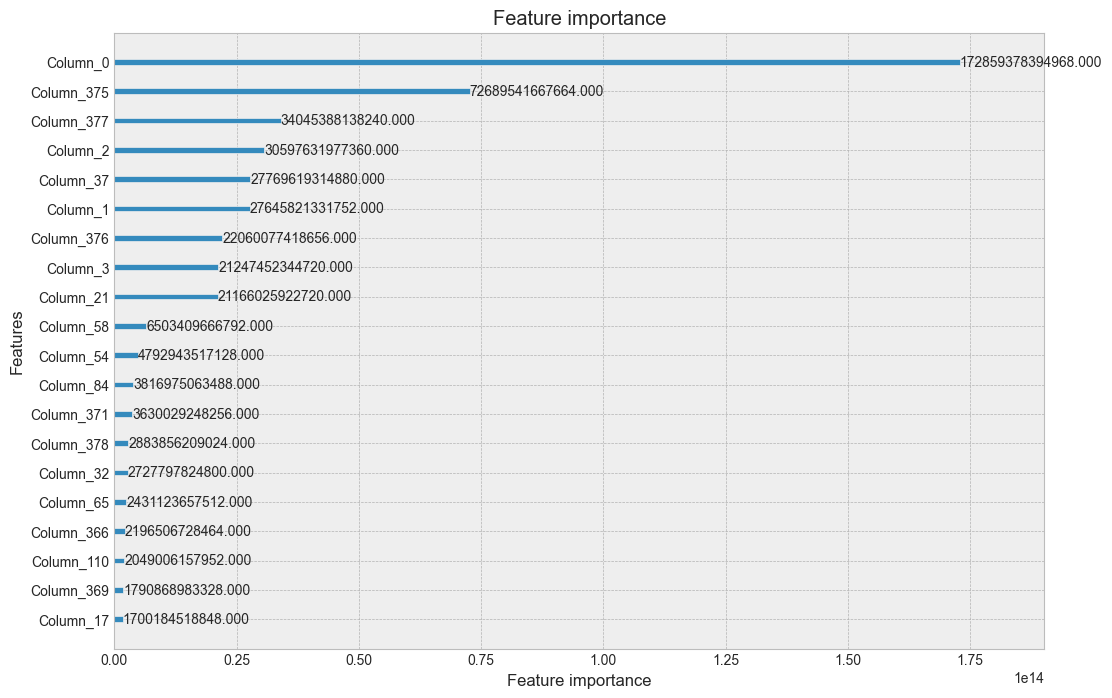

In [35]:
#get models from pipeline
test = best_model_lgbm['model']
plot_importance(test, max_num_features=20, importance_type='gain', figsize=(12, 8))

In [134]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Weighted Position LightGBM: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Top 5 Weighted Position Error LightGBM: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Gradient  LightGBM: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Top 5 LightGBM: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position LightGBM: 3.49
Top 5 Weighted Position Error LightGBM: 4.01
General Errors Gradient  LightGBM: MSE: 7.49, RMSE: 2.74, R2: 0.7000, MAE: 1.88
General Errors Top 5 LightGBM: MSE: 5.49, RMSE: 2.34, R2: -1.8075, MAE: 1.50


In [135]:
# save
# with open('lgbm.pkl','wb') as f:
#     pickle.dump(best_model_lgbm,f)

# load
with open('lgbm.pkl', 'rb') as f:
    best_model_lgbm = pickle.load(f)